<a href="https://colab.research.google.com/github/mikelevvra/GeiloAlberti/blob/main/Copy_of_Alberti_Geilo_2025_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning for Inverse Problems**
**Geilo Winter school 2025**


Goals of the lesson:

Use the library  _deep inverse_ to
*   simulate a deblurring problem
*   implement variational regularization strategies
*   use a Plug-and-Play scheme with a pre-trained denoiser
*   use a Plug-and-Play scheme, training a denoiser
*   implement and train a deep unfolding reconstruction method

Luca Ratti, Università di Bologna, luca.ratti5@unibo.it

Reference for the library: https://deepinv.github.io/deepinv/ by J. Tachella, D. Chen, S. Hurault, M. Terris and A Wang.

In [ ]:
%%capture
# Install deepinv (and ptwt, in case you need to use wavelets)
!pip install ptwt
!pip install git+https://github.com/deepinv/deepinv.git

In [ ]:
import deepinv as dinv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from pathlib import Path
from torchvision import transforms, datasets
#from deepinv.models.utils import get_weights_url

from deepinv.optim.prior import Prior, PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.training import test
from deepinv.models import DRUNet
from deepinv.optim.dpir import get_DPIR_params
from deepinv.models import DnCNN

# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(42)

# Specify the device (to use GPU on colab, first change the runtime to T4 GPU)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

# Use parallel dataloader if using a GPU to fasten training.
num_workers = 5 if torch.cuda.is_available() else 0

Selected GPU 0 with 15099 MiB free memory 


# **Create the physics: a deblurring + denoising problem**

Input: $a \in \mathbb{R}^{n \times n}(\cong \mathbb{R}^{n^2})\quad$  -  $\quad$ Output: $ b \in \mathbb{R}^{n \times n}(\cong \mathbb{R}^{n^2})$

Forward operator: convolution with a kernel (Point Spread Function) $k \in \mathbb{R}^{(2\nu+1)\times(2\nu+1)}$
$$ Fa = k * a, \qquad [Fa]_{i,j} = \sum_{p=-\nu}^\nu \sum_{q=-\nu}^\nu k_{p,q} a_{i-p,j-q}$$
(boundary conditions should be imposed on how to extend $a$ for indices $i,j$ before $1$ and after $n$)

Inverse problem: recover $a^+$ from $b = Fa^+ +\epsilon$, being $\epsilon \in \mathbb{R}^{n \times n}$ a random realization of Gaussian noise
$$ [\epsilon]_{i,j} \quad i.\!i.\!d. \sim \mathcal{N}(0,\delta^2)$$

In [ ]:
# Define the physics

# Blur: use a Gaussian filter k
#filter_0 = dinv.physics.blur.gaussian_blur(sigma=1).to(device=device) # vanilla filter: Gaussian of variance sigma Id
filter_0 = dinv.physics.blur.gaussian_blur(sigma=(1, 1), angle=0).to(device=device) # Gaussian with anisotropic variance, tilted of 45 degrees
# this filter simulates motion blur with a diagonal direction

# Noise model: additive gaussian
noise_level = 0.1  # delta
noise_model = dinv.physics.GaussianNoise(sigma=noise_level)

physics = dinv.physics.Blur(filter_0,padding='reflect',device=device,noise_model=noise_model)
# padding = 'reflect' specifies reflecting boundary conditions, avoiding jumps due to zero paddings

# **Create a dataset**

We start by importing the MNIST dataset of 28x28 images.

We then create a supervised dataset for the deblurring problem by constructing
$$ \{(b_i,a_i)\}_{i=1}^N, \qquad a_i \text{: an image from MNIST,}\quad b_i = Fa_i +\epsilon_i $$

Disclaimer: we use a rather small sample size $N$ to guarantee reasonable training times.

In [ ]:
%%capture
# Import the dataset
transform = transforms.Compose([transforms.ToTensor()])

Train_dataset = datasets.MNIST(root="../datasets/", train=True, transform=transform, download=True)
Test_dataset = datasets.MNIST(root="../datasets/", train=False, transform=transform, download=True)

# Create a supervised dataset of simulated measurements

# Specify the (maximum) size of the train and test sets
n_train_max = (250 if torch.cuda.is_available() else 50)  # number of images used for training
n_test_max = (50 if torch.cuda.is_available() else 10)  # number of images used for testing

# Set the path to save the datasets
BASE_DIR = Path(".")
measurement_dir = BASE_DIR / "dataset"

deepinv_datasets_path = dinv.datasets.generate_dataset(
    train_dataset=Train_dataset,
    test_dataset=Test_dataset,
    physics=physics,
    device=device,
    save_dir=measurement_dir,
    train_datapoints=n_train_max,
    test_datapoints=n_test_max,
    num_workers=num_workers,
    dataset_filename="deblur"
)

train_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=True)
test_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=False)

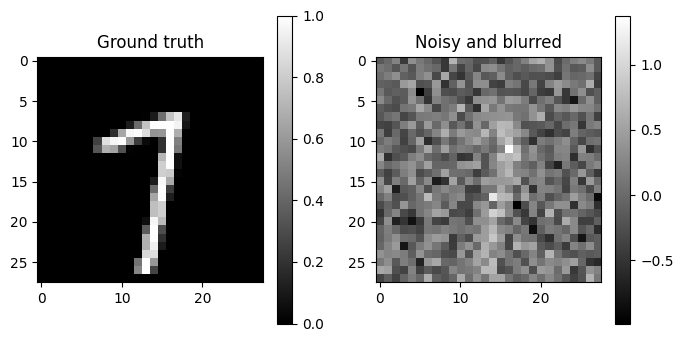

In [ ]:
# Vizualize images from the dataset

select_image = 42

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs0 = axs[0].imshow(train_dataset[select_image][0].squeeze(0), cmap='gray')
axs[0].set_title('Ground truth')
fig.colorbar(axs0)

axs1 = axs[1].imshow(train_dataset[select_image][1].squeeze(0), cmap='gray')
axs[1].set_title('Noisy and blurred')
fig.colorbar(axs1)


**********************************************************
**TASK 1**

Visualize the effect of a different blurring kernel $k$ and of a different noise level $\delta$.

Warning: when creating a new supervised dataset, always provide a new name to the variable 'dataset_filename'

**********************************************************

# **Variational regularization techniques**

Choose a regularization functional $R: \mathbb{R}^{n^2}\rightarrow \mathbb{R}$ and a parameter $\lambda >0 $ and solve
$$ a_\lambda = \arg\min_{a \in \mathbb{R}^{n^2}} \left\{ \frac{1}{2}\| Fa-b\|^2 + \lambda R(a)\right\}$$

Test:  98%|██████████████████████████████████████████████████████████████████████▌ | 49/50 [00:29<00:00,  1.81it/s, PSNR=13.4, PSNR no learning=-34.3]

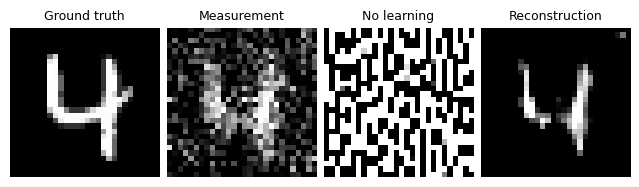

Test: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.67it/s, PSNR=13.4, PSNR no learning=-34.3]

Test results:
PSNR no learning: -34.349 +- 0.546
PSNR: 13.357 +- 1.962


{'PSNR no learning': -34.348971405029296,
 'PSNR no learning_std': 0.5455827038975948,
 'PSNR': 13.35700159072876,
 'PSNR_std': 1.9621460240445046}

In [ ]:
# Select the data fidelity term (the first part of the functional to be minimized)
data_fidelity = dinv.optim.data_fidelity.L2()

# Specify the custom prior R, e.g. Tikhonov, L1Prior, TVPrior, WaveletPrior
prior = dinv.optim.prior.L1Prior()

# Specific parameters for restoration with the given prior (Note that these parameters have not been optimized here)
params_algo = {"stepsize": .1, "lambda": 0.2}

# Instantiate the algorithm class to solve the IP problem.
modelVAR = optim_builder(
    iteration="PGD", # proximal gradient descent
    prior=prior,
    g_first=False,
    data_fidelity=data_fidelity,
    params_algo=params_algo,
    early_stop=True,
    max_iter=500,
    crit_conv="cost",
    thres_conv=1e-5,
    backtracking=False,
    verbose=False,
)


# The model does not need any training.
# To get its 'average performances' we apply it to all the elements of the test set and take an average

batch_size = 1
var_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

test(
    model=modelVAR,
    test_dataloader=var_dataloader,
    physics=physics,
    device=device,
    verbose=True,
    plot_images = True,
)


# also observe the "No learning" results, which are the reconstruction given by the pseudoinverse

**********************************************************
**TASK 2**

Explore alternative choices for $R$. Good candidates are Total Variation, or sparsity promotion with respect to wavelets: $R(a) = \| W a \|_1$ being $W$ a wavelet transform. Have a look at https://deepinv.github.io/deepinv/api/stubs/deepinv.optim.Prior.html#deepinv.optim.Prior


**********************************************************

## **Plug-and-Play 1: PGM with pre-trained denoiser**

Consider the Proximal-Gradient Method associated with the minimization of the functional $\frac{1}{2}\| Fa-b \|^2 + \lambda R(a)$, namely
$$
\left\{
\begin{aligned}
z^{(k+1)} &= a^{(k)} - \gamma F^T(Fa^{(k)}-b) \\
a^{(k+1)} &= \operatorname{prox}_{\gamma \lambda R}(z^{(k+1)})
\end{aligned}
\right.
$$
and replace the proximal operator of $\tau \lambda R$ by a neural network $D_{\theta,\sigma}$, obtaining
$$
\left\{
\begin{aligned}
z^{(k+1)} &= a^{(k)} - \gamma F^T(Fa^{(k)}-b) \\
a^{(k+1)} &= D_{\theta,\sigma}(z^{(k+1)})
\end{aligned}
\right.
$$
The network $D_{\theta,\sigma}$ (depending on some parameters $\theta$) plays the role of a denoiser, and in particular it is trained to remove Gaussian noise, i.e., to approximate the Minimum MSE denoiser associated with the prior distribution corrupted by Gaussian noise with standard deviation $\sigma$.

Let us first consider a simple case in which $D_{\theta,\sigma}$ is a CNN that has been pre-trained on natural images.




Downloading: "https://huggingface.co/deepinv/dncnn/resolve/main/dncnn_sigma2_gray.pth?download=true" to /root/.cache/torch/hub/checkpoints/dncnn_sigma2_gray.pth
100%|██████████| 2.55M/2.55M [00:00<00:00, 46.3MB/s]
Test:  98%|██████████████████████████████████████████████████████████████████████▌ | 49/50 [00:22<00:00,  3.03it/s, PSNR=17.9, PSNR no learning=-16.3]

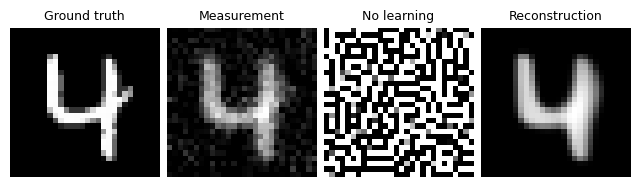

Test: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.20it/s, PSNR=17.9, PSNR no learning=-16.3]

Test results:
PSNR no learning: -16.317 +- 0.456
PSNR: 17.905 +- 1.255


{'PSNR no learning': -16.317142810821533,
 'PSNR no learning_std': 0.45581130240881484,
 'PSNR': 17.9051619720459,
 'PSNR_std': 1.2549202039095193}

In [ ]:
from deepinv.models import DnCNN

sigma_PnP = 0.05
params_algo = {"stepsize": 0.01, "g_param": sigma_PnP}
max_iter = 100
early_stop = True

denoiser = DnCNN(
    in_channels=1,
    out_channels=1,
    pretrained="download",  # try also download_lipschitz.
    device=device,
)
prior = PnP(denoiser=denoiser)

data_fidelity = dinv.optim.data_fidelity.L2()


# Instantiate the algorithm class to solve the IP problem.
modelPnP = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=True,
    params_algo=params_algo,
)
modelPnP.eval() # set the model to evaluation mode. We do not require training here.


# Set the data loader to test the regularizer
batch_size = 1
var_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

test(
    model=modelPnP,
    test_dataloader=var_dataloader,
    physics=physics,
    device=device,
    verbose=True,
    plot_images = True,
)


# what is the effect of a different choice of sigma?

# **Plug-and-Play 2: let's also train the denoiser**

Let us use in PGM a network specifically trained to denoise images from the MNIST dataset.
To do so,
1.   we create another dataset $\{\tilde{a}_i,a_i\}_{i=1}^{N_{den}}$ such that $\tilde{a}_i = a_i + \tilde{\epsilon}_i$, where $\tilde{\epsilon}_i \sim \mathcal{N}(0,\sigma^2 I)$
2.   we define a denoiser $D_\theta$ as a CNN as above and train it, namely we choose its parameters $\theta$ so to minimize $$L_{den}(\theta) = \frac{1}{N_{den}} \sum_{i=1}^{N_{den}} \| D_\theta(\tilde{a}_i) - a_i\|^2$$
3.  we use the trained denoiser $ D_{\theta,\sigma}$ in place of the prox of a regularization functional in any PnP scheme - e.g. PnP-PGD.


In [ ]:
# Part 1: dataset

sigma_PnP = 0.1

denoiser_train = DnCNN(   # Try also a UNet
    in_channels=1,
    out_channels=1,
    pretrained="download",
    device=device,
)
# Create a supervised dataset of simulated measurements

# Specify the (maximum) size of the train and test sets
n_train_max_PnP = (250 if torch.cuda.is_available() else 50)  # number of images used for training
n_test_max_PnP = (50 if torch.cuda.is_available() else 10)  # number of images used for testing

# Set the path to save the datasets
BASE_DIR = Path(".")
measurement_dir = BASE_DIR / "dataset"

# Define the physics
noise_model_PnP = dinv.physics.GaussianNoise(sigma=sigma_PnP)
physics_PnP = dinv.physics.Denoising(device=device,noise_model=noise_model_PnP)

deepinv_datasets_path_PnP = dinv.datasets.generate_dataset(
    train_dataset=Train_dataset,
    test_dataset=Test_dataset,
    physics=physics_PnP,
    device=device,
    save_dir=measurement_dir,
    train_datapoints=n_train_max_PnP,
    test_datapoints=n_test_max_PnP,
    num_workers=num_workers,
    dataset_filename="denoise",
)

train_dataset_PnP = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path_PnP, train=True)
test_dataset_PnP = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path_PnP, train=False)

/usr/local/lib/python3.11/dist-packages/deepinv/datasets/datagenerator.py:242: UserWarning: Dataset dataset/denoise0.h5 already exists, this will overwrite the previous dataset.
  warn(


Dataset has been saved at dataset/denoise0.h5


The model has 665921 trainable parameters
Train epoch 0: TotalLoss=0.011, PSNR=19.777
Eval epoch 0: PSNR=20.066
Train epoch 1: TotalLoss=0.009, PSNR=20.664
Eval epoch 1: PSNR=21.753
Train epoch 2: TotalLoss=0.005, PSNR=22.786
Eval epoch 2: PSNR=24.007
Train epoch 3: TotalLoss=0.003, PSNR=25.49
Eval epoch 3: PSNR=26.927
Train epoch 4: TotalLoss=0.002, PSNR=27.214
Eval epoch 4: PSNR=27.871
Train epoch 5: TotalLoss=0.002, PSNR=28.104
Eval epoch 5: PSNR=28.644
Train epoch 6: TotalLoss=0.001, PSNR=28.514
Eval epoch 6: PSNR=28.914
Train epoch 7: TotalLoss=0.001, PSNR=28.802
Eval epoch 7: PSNR=29.195
Train epoch 8: TotalLoss=0.001, PSNR=29.106
Eval epoch 8: PSNR=29.485
Train epoch 9: TotalLoss=0.001, PSNR=29.296
Eval epoch 9: PSNR=29.415
Train epoch 10: TotalLoss=0.001, PSNR=29.452
Eval epoch 10: PSNR=29.813
Train epoch 11: TotalLoss=0.001, PSNR=29.66
Eval epoch 11: PSNR=29.643
Train epoch 12: TotalLoss=0.001, PSNR=29.711
Eval epoch 12: PSNR=30.015
Train epoch 13: TotalLoss=0.001, PSNR=29.889

Test:   0%|                                                                                     | 0/5 [00:00<?, ?it/s, PSNR=30.2, PSNR no learning=20]

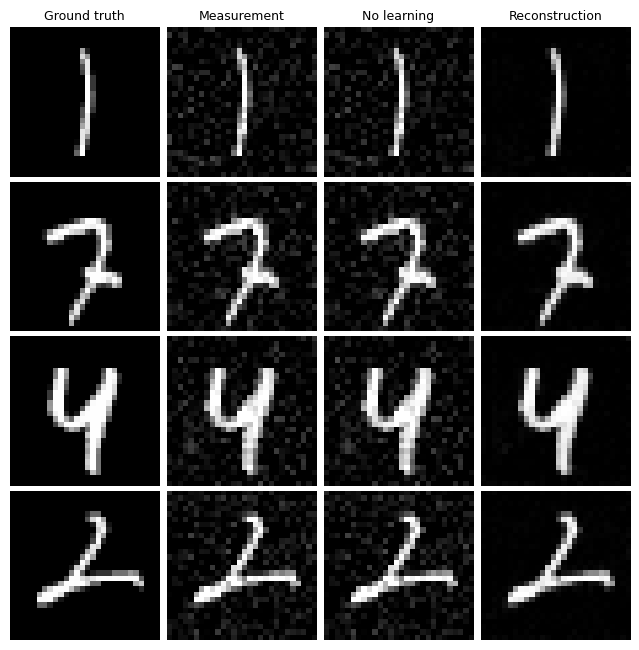

Test: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.66it/s, PSNR=30.2, PSNR no learning=20]

Test results:
PSNR no learning: 20.025 +- 0.226
PSNR: 30.164 +- 1.486


DnCNN(
  (in_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_list): ModuleList(
    (0-17): 18 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out_conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nl_list): ModuleList(
    (0-18): 19 x ReLU()
  )
)

In [ ]:
# Part 2: training

data_fidelity = dinv.optim.data_fidelity.L2()

# Set the dataloader for the training
batch_size=10
train_dataloader_PnP = DataLoader(train_dataset_PnP, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader_PnP = DataLoader(test_dataset_PnP, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Set the training algorithm
learning_rate = 1e-3
epochs = 20
optimizer = torch.optim.Adam(denoiser_train.parameters(), lr=learning_rate)
losses = [dinv.loss.SupLoss(metric=dinv.loss.metric.MSE())]

trainer_den = dinv.Trainer(
    model=denoiser_train,
    physics=physics_PnP,
    train_dataloader=train_dataloader_PnP,
    eval_dataloader=test_dataloader_PnP,
    epochs=epochs,
    losses=losses,
    optimizer=optimizer,
    device=device,
    verbose=True,
    show_progress_bar=False,
)
# Training
modelDenoiser = trainer_den.train()
test(
    model=denoiser_train,
    test_dataloader=test_dataloader_PnP,
    physics=physics_PnP,
    device=device,
    verbose=True,
    plot_images = True,
)

# Training is over: now let us use the trained model
modelDenoiser.eval()

**********************************************************
**TASK 4**

Use the trained denoiser within a simple PnP-PGD scheme.

Hint: since the prior is strong, you can use a small regularization parameter. This is encoded by selecting a large stepsize.


**********************************************************

Test:  42%|██████████████████████████████▏                                         | 21/50 [00:06<00:10,  2.66it/s, PSNR=16.6, PSNR no learning=-34.3]

Iteration 89, current converge crit. = 9.52E-06, objective = 1.00E-05 


Test:  98%|██████████████████████████████████████████████████████████████████████▌ | 49/50 [00:18<00:00,  3.20it/s, PSNR=16.4, PSNR no learning=-34.4]

Iteration 95, current converge crit. = 9.38E-06, objective = 1.00E-05 


Test:  98%|██████████████████████████████████████████████████████████████████████▌ | 49/50 [00:18<00:00,  3.20it/s, PSNR=16.4, PSNR no learning=-34.3]

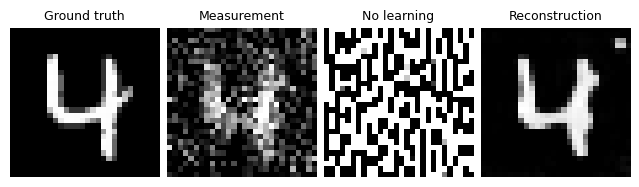

Test: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.69it/s, PSNR=16.4, PSNR no learning=-34.3]

Test results:
PSNR no learning: -34.349 +- 0.546
PSNR: 16.365 +- 2.082


{'PSNR no learning': -34.348971405029296,
 'PSNR no learning_std': 0.5455827038975948,
 'PSNR': 16.36458515167236,
 'PSNR_std': 2.0819758508559194}

In [ ]:
# Part 3: use the trained denoiser within a PnP-PGD scheme

sigma_PnP = 0.1
params_algo = {"stepsize": 1, "g_param": sigma_PnP}
max_iter = 100
early_stop = True


prior = PnP(denoiser=modelDenoiser)

data_fidelity = dinv.optim.data_fidelity.L2()


# Instantiate the algorithm class to solve the IP problem.
modelPnP = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=True,
    params_algo=params_algo,
)
modelPnP.eval() # set the model to evaluation mode. We do not require training here.


# Set the data loader to test the regularizer
batch_size = 1
var_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

test(
    model=modelPnP,
    test_dataloader=var_dataloader,
    physics=physics,
    device=device,
    verbose=True,
    plot_images = True,
)



# **Unrolling**

We consider the iterates of a Douglas-Rachford scheme for the minimization of $\frac{1}{2} \| Fa-b\|^2 + \lambda R(a)$, namely:
$$
\left\{
\begin{aligned}
z^{(k+1)} &= \operatorname{prox}_{\tau \|F\cdot - b\|^2}(a^{(k)})\\
y^{(k+1)} &= \operatorname{prox}_{\tau \lambda R}(2z^{(k+1)}-a^{(k)}) \\
a^{(k+1)} &= a^{(k)} + \beta(y^{(k+1)}-z^{(k+1)})
\end{aligned}
\right.
$$
where $\tau$ is a stepsize and $\beta$ a relaxation parameter.
Replace the proximal of the regularization functional with a different CNN $N_{\theta_k}$ at each iteration:
$$
\left\{
\begin{aligned}
z^{(k+1)} &= \operatorname{prox}_{\tau \|F\cdot - b\|^2}(a^{(k)})\\
y^{(k+1)} &= N_{\theta_k}(2z^{(k+1)}-a^{(k)}) \\
a^{(k+1)} &= a^{(k)} + \beta (y^{(k+1)}-z^{(k+1)})
\end{aligned}
\right.
$$

For a fixed number of iterates $K$, we define $H_\theta$ the map that takes as an input $b$ and returns $a^{(K)}$, and interpret it as a (very deep) neural network, where $\theta$ denotes the collection of all the parameters in the network. We train the network by minimizing $$L(\theta) = \frac{1}{N} \sum_{i=1}^{N} \| H_\theta(b_i) - a_i\|^2$$

The model has 185859 trainable parameters
Train epoch 0: TotalLoss=0.199, PSNR=10.48
Eval epoch 0: PSNR=14.269
Train epoch 1: TotalLoss=0.036, PSNR=14.645
Eval epoch 1: PSNR=15.793
Train epoch 2: TotalLoss=0.028, PSNR=15.797
Eval epoch 2: PSNR=16.531
Train epoch 3: TotalLoss=0.024, PSNR=16.362
Eval epoch 3: PSNR=16.867
Train epoch 4: TotalLoss=0.023, PSNR=16.712
Eval epoch 4: PSNR=17.086
Train epoch 5: TotalLoss=0.022, PSNR=16.897
Eval epoch 5: PSNR=17.218
Train epoch 6: TotalLoss=0.021, PSNR=17.017
Eval epoch 6: PSNR=17.311
Train epoch 7: TotalLoss=0.021, PSNR=17.143
Eval epoch 7: PSNR=17.46
Train epoch 8: TotalLoss=0.02, PSNR=17.286
Eval epoch 8: PSNR=17.568
Train epoch 9: TotalLoss=0.02, PSNR=17.385
Eval epoch 9: PSNR=17.617
Train epoch 10: TotalLoss=0.019, PSNR=17.445
Eval epoch 10: PSNR=17.663
Train epoch 11: TotalLoss=0.019, PSNR=17.509
Eval epoch 11: PSNR=17.725
Train epoch 12: TotalLoss=0.019, PSNR=17.575
Eval epoch 12: PSNR=17.765
Train epoch 13: TotalLoss=0.019, PSNR=17.626
E

Test:  80%|███████████████████████████████████████████████████████████▏              | 4/5 [00:00<00:00,  7.89it/s, PSNR=17.8, PSNR no learning=-34.3]

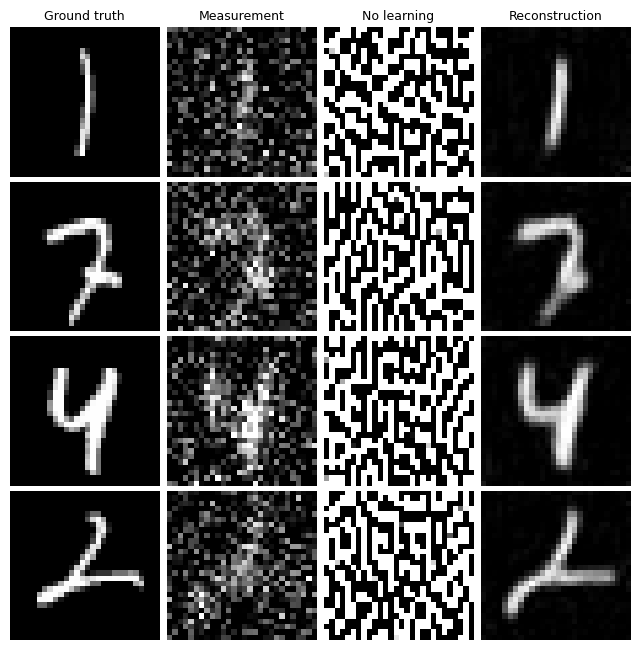

Test: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.82it/s, PSNR=17.8, PSNR no learning=-34.3]

Test results:
PSNR no learning: -34.350 +- 0.546
PSNR: 17.797 +- 2.117


{'PSNR no learning': -34.34973937988281,
 'PSNR no learning_std': 0.5463249402854593,
 'PSNR': 17.79657257080078,
 'PSNR_std': 2.116966165966364}

In [ ]:
# Select the denoiser
priorUnr = dinv.optim.PnP(dinv.models.DnCNN(in_channels=1, out_channels=1,depth=7, pretrained=None).to(device))

# Define the unrolled architecture
modelUnr = dinv.unfolded.unfolded_builder(
    iteration="DRS",
    data_fidelity=dinv.optim.L2(),
    prior=priorUnr,
    params_algo={"stepsize": 1.0, "g_param": 1.0},
    trainable_params=["stepsize", "g_param"],
    device=device
)

# Set the dataloader for the training
batch_size=10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Set the training algorithm
learning_rate = 1e-3
epochs = 20
optimizer = torch.optim.Adam(modelUnr.parameters(), lr=learning_rate)
losses = [dinv.loss.SupLoss(metric=dinv.loss.metric.MSE())]

trainer = dinv.Trainer(
    model=modelUnr,
    physics=physics,
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    epochs=epochs,
    losses=losses,
    optimizer=optimizer,
    device=device,
    verbose=True,
    show_progress_bar=False,
)

# Training
model = trainer.train()

# Testing
test(model=modelUnr,
    test_dataloader=test_dataloader,
    physics=physics,
    device=device,
    plot_images=True,
    verbose=True,
)